In [3]:
# Cell 1: Setup & Installation
!pip install "pandas<2.0.0"
!pip install drain3 torch transformers scikit-learn

In [ ]:
# Cell 2 
import pandas as pd
from drain3 import TemplateMiner
from drain3.template_miner_config import TemplateMinerConfig
import os

TOTAL_LINES_TO_PROCESS = 2500000 
log_file_path = '/kaggle/input/loghub-windows-dataset/Windows.log'

config = TemplateMinerConfig()
template_miner = TemplateMiner(config=config)
all_parsed_logs = []
line_count = 0

print(f"Starting parsing for a unified vocabulary (up to {TOTAL_LINES_TO_PROCESS} lines)...")
try:
    with open(log_file_path, 'r', encoding='utf-8', errors='ignore') as f:
        for line in f:
            if line_count >= TOTAL_LINES_TO_PROCESS: break
            log_message = line.strip()
            if not log_message: continue
            result = template_miner.add_log_message(log_message)
            line_count += 1
            all_parsed_logs.append({'EventId': f"E{result['cluster_id']}", 'OriginalLog': log_message})
            if line_count % 250000 == 0: print(f"Processed {line_count} lines...")
except FileNotFoundError:
    print(f"Error: The file was not found at {log_file_path}.")

print(f"\nLog parsing complete. Total lines: {len(all_parsed_logs)}")
df_full = pd.DataFrame(all_parsed_logs)

print("\n--- Parsed Log Data Sample ---")
print(df_full.head())
print(f"\nTotal unique log templates found: {len(template_miner.drain.clusters)}")

Starting parsing for a unified vocabulary (up to 2500000 lines)...
Processed 250000 lines...
Processed 500000 lines...
Processed 750000 lines...
Processed 1000000 lines...
Processed 1250000 lines...
Processed 1500000 lines...
Processed 1750000 lines...
Processed 2000000 lines...
Processed 2250000 lines...
Processed 2500000 lines...

Log parsing complete. Total lines: 2500000

--- Parsed Log Data Sample ---
  EventId                                        OriginalLog
0      E1  ﻿2016-09-28 04:30:30, Info                  CB...
1      E2  2016-09-28 04:30:30, Info                  CBS...
2      E3  2016-09-28 04:30:31, Info                  CSI...
3      E3  2016-09-28 04:30:31, Info                  CSI...
4      E3  2016-09-28 04:30:31, Info                  CSI...

Total unique log templates found: 479


In [ ]:
# Cell 3 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from transformers import BertConfig, BertModel
from tqdm import tqdm
import pickle
from torch.amp import GradScaler, autocast

# ===================================================================
# 1. Data Preparation
# ===================================================================
event_ids = df_full['EventId'].unique()
vocab = {event_id: i for i, event_id in enumerate(event_ids)}
vocab['[MASK]'] = len(vocab)
vocab_size = len(vocab)
print(f"Unified vocabulary size: {vocab_size}")

train_val_df, test_df = train_test_split(df_full, test_size=0.1, random_state=42)
train_df, val_df = train_test_split(train_val_df, test_size=1/9, random_state=42)

print(f"Training set size: {len(train_df)} lines")
print(f"Validation set size: {len(val_df)} lines")
print(f"Test set size: {len(test_df)} lines")

class LogDataset(Dataset):
    def __init__(self, dataframe, vocab, seq_len=128):
        self.data = dataframe['EventId'].tolist()
        self.vocab = vocab
        self.seq_len = seq_len
    def __len__(self):
        return len(self.data) - self.seq_len + 1
    def __getitem__(self, idx):
        sequence_events = self.data[idx : idx + self.seq_len]
        sequence_indices = [self.vocab.get(event_id, 0) for event_id in sequence_events]
        return torch.tensor(sequence_indices, dtype=torch.long)

sequence_length = 128 
batch_size = 256
train_dataset = LogDataset(train_df, vocab, seq_len=sequence_length)
val_dataset = LogDataset(val_df, vocab, seq_len=sequence_length)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

# ===================================================================
# 2. Model Definition
# ===================================================================
class LogBERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=4, num_attention_heads=4, max_seq_len=128):
        super(LogBERT, self).__init__()
        config = BertConfig(vocab_size=vocab_size, hidden_size=hidden_size, num_hidden_layers=num_layers, num_attention_heads=num_attention_heads, max_position_embeddings=max_seq_len + 2)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        return self.classifier(outputs.last_hidden_state)

# ===================================================================
# 3. Training Execution
# ===================================================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
model = LogBERT(vocab_size=vocab_size, max_seq_len=sequence_length).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
scaler = GradScaler()
num_epochs, patience, best_val_loss, epochs_no_improve = 25, 3, float('inf'), 0
best_model_path = 'logbert_best_model_unified_vocab.pth'

for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch + 1}/{num_epochs} ---")
    model.train()
    total_train_loss = 0
    for sequence in tqdm(train_loader, desc="Training"):
        sequence, labels = sequence.to(device), sequence.clone().to(device)
        prob = 0.15 
        mask = torch.rand(sequence.shape, device=device) < prob
        sequence[mask] = vocab['[MASK]']
        labels[~mask] = -100  
        optimizer.zero_grad(set_to_none=True)
        with autocast(device_type=device.type, dtype=torch.float16):
            outputs = model(sequence)
            loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_train_loss += loss.item()
    print(f"Average Training Loss: {total_train_loss / len(train_loader):.4f}")

    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for sequence in tqdm(val_loader, desc="Validating"):
            sequence, labels = sequence.to(device), sequence.clone().to(device)
            prob = 0.15
            mask = torch.rand(sequence.shape, device=device) < prob
            sequence[mask] = vocab['[MASK]']
            labels[~mask] = -100
            with autocast(device_type=device.type, dtype=torch.float16):
                outputs = model(sequence)
                loss = criterion(outputs.view(-1, vocab_size), labels.view(-1))
            total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss, epochs_no_improve = avg_val_loss, 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Validation loss improved. Saving best model to {best_model_path}")
    else:
        epochs_no_improve += 1
        print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
    if epochs_no_improve >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break
print(f"\n--- Training Finished ---")

# ===================================================================
# 4. Save the Unified Vocabulary for Testing
# ===================================================================
with open('vocab_unified.pkl', 'wb') as f:
    pickle.dump(vocab, f)
print("Unified vocabulary saved to vocab_unified.pkl")

Unified vocabulary size: 480
Training set size: 2000000 lines
Validation set size: 250000 lines
Test set size: 250000 lines
Using device: cuda

--- Epoch 1/25 ---


Training: 100%|██████████| 7813/7813 [22:30<00:00,  5.78it/s]


Average Training Loss: 1.8665


Validating: 100%|██████████| 977/977 [00:59<00:00, 16.44it/s]


Validation Loss: 1.8583
Validation loss improved. Saving best model to logbert_best_model_unified_vocab.pth

--- Epoch 2/25 ---


Training: 100%|██████████| 7813/7813 [22:35<00:00,  5.76it/s]


Average Training Loss: 1.8584


Validating: 100%|██████████| 977/977 [00:59<00:00, 16.46it/s]


Validation Loss: 1.8585
No improvement in validation loss for 1 epoch(s).

--- Epoch 3/25 ---


Training: 100%|██████████| 7813/7813 [22:20<00:00,  5.83it/s]


Average Training Loss: 1.8576


Validating: 100%|██████████| 977/977 [00:58<00:00, 16.63it/s]


Validation Loss: 1.8580
Validation loss improved. Saving best model to logbert_best_model_unified_vocab.pth

--- Epoch 4/25 ---


Training: 100%|██████████| 7813/7813 [22:22<00:00,  5.82it/s]


Average Training Loss: 1.8574


Validating: 100%|██████████| 977/977 [00:58<00:00, 16.76it/s]


Validation Loss: 1.8588
No improvement in validation loss for 1 epoch(s).

--- Epoch 5/25 ---


Training: 100%|██████████| 7813/7813 [22:11<00:00,  5.87it/s]


Average Training Loss: 1.8578


Validating: 100%|██████████| 977/977 [00:57<00:00, 16.92it/s]


Validation Loss: 1.8581
No improvement in validation loss for 2 epoch(s).

--- Epoch 6/25 ---


Training: 100%|██████████| 7813/7813 [22:06<00:00,  5.89it/s]


Average Training Loss: 1.8578


Validating: 100%|██████████| 977/977 [00:57<00:00, 16.85it/s]


Validation Loss: 1.8579
Validation loss improved. Saving best model to logbert_best_model_unified_vocab.pth

--- Epoch 7/25 ---


Training: 100%|██████████| 7813/7813 [22:00<00:00,  5.92it/s]


Average Training Loss: 1.8575


Validating: 100%|██████████| 977/977 [00:57<00:00, 16.88it/s]


Validation Loss: 1.8582
No improvement in validation loss for 1 epoch(s).

--- Epoch 8/25 ---


Training: 100%|██████████| 7813/7813 [22:03<00:00,  5.90it/s]


Average Training Loss: 1.8576


Validating: 100%|██████████| 977/977 [00:58<00:00, 16.70it/s]


Validation Loss: 1.8584
No improvement in validation loss for 2 epoch(s).

--- Epoch 9/25 ---


Training: 100%|██████████| 7813/7813 [22:14<00:00,  5.85it/s]


Average Training Loss: 1.8577


Validating: 100%|██████████| 977/977 [00:59<00:00, 16.49it/s]

Validation Loss: 1.8583
No improvement in validation loss for 3 epoch(s).

Early stopping triggered after 9 epochs.

--- Training Finished ---
Unified vocabulary saved to vocab_unified.pkl


In [11]:
# Cell 4: Testing the Model on the Held-Out Test Set
import torch, torch.nn as nn
from transformers import BertConfig, BertModel
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import pickle
import pandas as pd

# ===================================================================
# 1. Setup and Load the Saved Model and UNIFIED Vocabulary
# ===================================================================
# Model definition must be available
class LogBERT(nn.Module):
    def __init__(self, vocab_size, hidden_size=256, num_layers=4, num_attention_heads=4, max_seq_len=128):
        super(LogBERT, self).__init__()
        config = BertConfig(vocab_size=vocab_size, hidden_size=hidden_size, num_hidden_layers=num_layers, num_attention_heads=num_attention_heads, max_position_embeddings=max_seq_len + 2)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(hidden_size, vocab_size)
    def forward(self, input_ids):
        outputs = self.bert(input_ids=input_ids)
        return self.classifier(outputs.last_hidden_state)

# Load the UNIFIED vocabulary
with open('vocab_unified.pkl', 'rb') as f:
    vocab = pickle.load(f)
vocab_size = len(vocab)
sequence_length = 128
print("Unified vocabulary loaded successfully.")

# Initialize model and load the best weights from the new training run
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LogBERT(vocab_size=vocab_size, max_seq_len=sequence_length).to(device)
model.load_state_dict(torch.load('logbert_best_model_unified_vocab.pth'))
model.eval()
print("Best model (trained on unified vocab) loaded successfully.")

# ===================================================================
# 2. Prepare the Test Data (using the test_df from Cell 3)
# ===================================================================
class TestLogDataset(Dataset):
    def __init__(self, dataframe, vocab, seq_len=128):
        self.df = dataframe
        self.vocab = vocab
        self.seq_len = seq_len
    def __len__(self):
        return len(self.df) - self.seq_len + 1
    def __getitem__(self, idx):
        sequence_events = self.df['EventId'].iloc[idx:idx+self.seq_len].tolist()
        original_logs = self.df['OriginalLog'].iloc[idx:idx+self.seq_len].tolist()
        sequence_indices = [self.vocab.get(event_id, 0) for event_id in sequence_events]
        return torch.tensor(sequence_indices, dtype=torch.long), original_logs

def collate_fn(batch):
    sequences, original_logs = zip(*batch)
    return torch.stack(sequences, dim=0), list(original_logs)

test_dataset = TestLogDataset(test_df, vocab, seq_len=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=collate_fn)

# ===================================================================
# 3. Anomaly Detection on the Test Set
# ===================================================================
print("\nStarting anomaly detection on the held-out test set...")
anomalous_sequences = []
G, R = 9, 3 

with torch.no_grad():
    for sequences, original_logs_batch in tqdm(test_loader, desc="Detecting Anomalies"):
        sequences = sequences.to(device)
        predictions = model(sequences)
        top_g_predictions = torch.topk(predictions, G, dim=2).indices
        
        for i in range(sequences.shape[0]):
            mismatch_count = 0
            for j in range(sequences.shape[1]):
                if sequences[i, j].item() not in top_g_predictions[i, j]:
                    mismatch_count += 1
            if mismatch_count > R:
                anomalous_sequences.append({"mismatches": mismatch_count, "sequence": original_logs_batch[i]})

print(f"\n--- Detection Complete ---")
print(f"Total sequences tested: {len(test_dataset)}")
print(f"Anomalous sequences found: {len(anomalous_sequences)}")

# Print the first 5 detected anomalies
for i, anomaly in enumerate(anomalous_sequences[:5]):
    print(f"\n--- Anomaly #{i+1} (Mismatches: {anomaly['mismatches']}) ---")
    for log_line in anomaly['sequence']:
        print(log_line)

Unified vocabulary loaded successfully.
Best model (trained on unified vocab) loaded successfully.

Starting anomaly detection on the held-out test set...


Detecting Anomalies: 100%|██████████| 977/977 [36:10<00:00,  2.22s/it]


--- Detection Complete ---
Total sequences tested: 249873
Anomalous sequences found: 247219

--- Anomaly #1 (Mismatches: 6) ---
2016-10-17 03:20:05, Info                  CBS    Appl: detect Parent, Package: Package_for_KB2758857_RTM~31bf3856ad364e35~amd64~~6.1.1.0, Parent: Microsoft-Windows-WinPE-LanguagePack-Package~31bf3856ad364e35~amd64~sv-SE~6.1.7601.17514, Disposition = Detect, VersionComp: EQ, ServiceComp: EQ, BuildComp: EQ, DistributionComp: GE, RevisionComp: GE, Exist: present
2016-10-17 03:22:40, Info                  CBS    Appl: Selfupdate, Component: amd64_microsoft-windows-lsa.resources_31bf3856ad364e35_0.0.0.0_es-es_066bc2669749f638 (6.1.7601.22923), elevation:2, lower version revision holder: 0.0.0.0
2016-10-11 03:09:04, Info                  CBS    Appl: detect Parent, Package: Package_208_for_KB2871997~31bf3856ad364e35~amd64~~6.1.2.5, Parent: Microsoft-Windows-EmbeddedFoundation-Base-LanguagePack-Package~31bf3856ad364e35~amd64~ar-SA~6.1.7601.17514, Disposition = Dete

Starting results analysis...


Calculating all mismatch scores: 100%|██████████| 977/977 [36:02<00:00,  2.21s/it]



--- Mismatch Score Analysis ---
count    249873.000000
mean          9.662525
std           2.924002
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          23.000000
dtype: float64


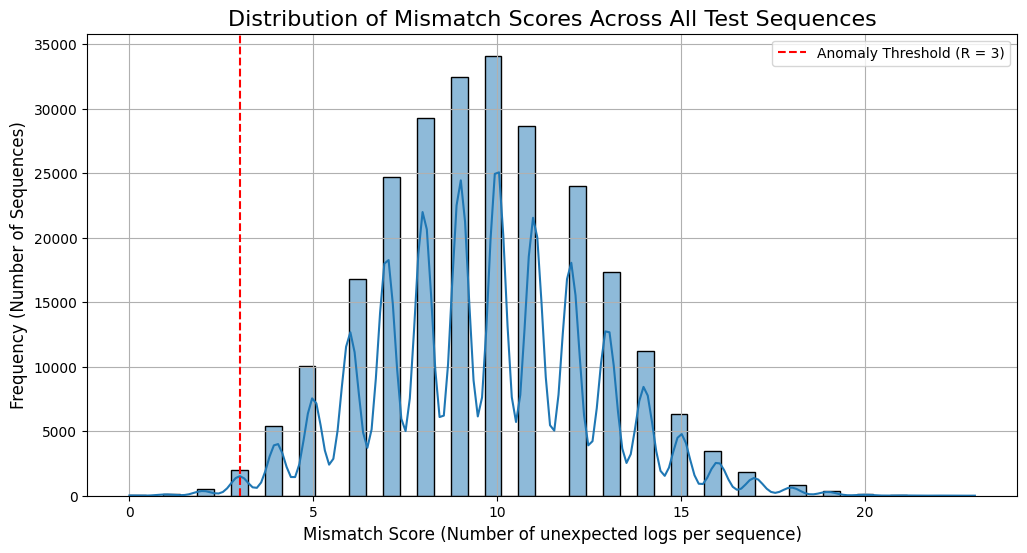


--- Anomaly Detection Summary ---
Total sequences evaluated: 249873
Anomaly Threshold (R): A sequence is anomalous if it has > 3 mismatches.
-----------------------------------
Predicted Normal Sequences: 2654
Predicted Anomalous Sequences: 247219
-----------------------------------
Calculated Anomaly Rate: 98.94%

--- Inspecting Top 5 Most Anomalous Sequences ---

--- Top Anomaly #1 (Mismatches: 23) ---
>>> Unique templates in this anomalous sequence:
    - <*> <*> Info CBS Appl: detect Parent, Package: <*> disposition state from detectParent: <*>
    - <*> <*> Info CBS Appl: detect Parent, Package: <*> Parent: <*> Disposition = <*> VersionComp: EQ, ServiceComp: <*> BuildComp: <*> DistributionComp: GE, RevisionComp: GE, Exist: present
    - <*> <*> Info CBS Applicability(ComponentAnalyzerEvaluateSelfUpdate): Component: <*> elevate: <*> applicable(true/false): <*>
    - 2016-10-17 <*> Info CBS Appl: detectParent: package: <*> <*> <*> <*> <*> <*>
    - <*> <*> Info CBS Appl: SelfUpdate

In [12]:
# Cell 5: Results Evaluation and Visualization

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("Starting results analysis...")

# ===================================================================
# 1. Analyze the Mismatch Distribution (Most Important Step)
# ===================================================================

# First, we need the mismatch scores for ALL sequences, not just the anomalous ones.
# Let's re-run the detection loop to capture every score.

all_mismatch_scores = []
with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Calculating all mismatch scores")
    for sequences, _ in progress_bar:
        sequences = sequences.to(device)
        predictions = model(sequences)
        top_g_predictions = torch.topk(predictions, G, dim=2).indices
        
        for i in range(sequences.shape[0]):
            mismatch_count = 0
            for j in range(sequences.shape[1]):
                if sequences[i, j].item() not in top_g_predictions[i, j]:
                    mismatch_count += 1
            all_mismatch_scores.append(mismatch_count)

print("\n--- Mismatch Score Analysis ---")
scores_series = pd.Series(all_mismatch_scores)
print(scores_series.describe())

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(all_mismatch_scores, bins=50, kde=True)
plt.title('Distribution of Mismatch Scores Across All Test Sequences', fontsize=16)
plt.xlabel('Mismatch Score (Number of unexpected logs per sequence)', fontsize=12)
plt.ylabel('Frequency (Number of Sequences)', fontsize=12)

# Add a vertical line for our anomaly threshold 'R'
# R was set in the previous testing cell. Let's define it here again for clarity.
R = 3 
plt.axvline(x=R, color='r', linestyle='--', label=f'Anomaly Threshold (R = {R})')
plt.legend()
plt.grid(True)
plt.show()

# ===================================================================
# 2. Simulate a Confusion Matrix & Key Metrics
# ===================================================================

# Based on our threshold 'R', we can calculate our "predicted" labels.
predicted_anomalies = sum(1 for score in all_mismatch_scores if score > R)
predicted_normals = len(all_mismatch_scores) - predicted_anomalies

# Create a simple summary table (simulated confusion matrix)
print("\n--- Anomaly Detection Summary ---")
print(f"Total sequences evaluated: {len(all_mismatch_scores)}")
print(f"Anomaly Threshold (R): A sequence is anomalous if it has > {R} mismatches.")
print("-" * 35)
print(f"Predicted Normal Sequences: {predicted_normals}")
print(f"Predicted Anomalous Sequences: {predicted_anomalies}")
print("-" * 35)
anomaly_rate = (predicted_anomalies / len(all_mismatch_scores)) * 100 if len(all_mismatch_scores) > 0 else 0
print(f"Calculated Anomaly Rate: {anomaly_rate:.2f}%")


# ===================================================================
# 3. Qualitative Analysis: Inspect Top Anomalies
# ===================================================================

print("\n--- Inspecting Top 5 Most Anomalous Sequences ---")

# Sort the anomalous sequences by the number of mismatches in descending order
# The `anomalous_sequences` list was generated in the previous testing cell
sorted_anomalies = sorted(anomalous_sequences, key=lambda x: x['mismatches'], reverse=True)

for i, anomaly in enumerate(sorted_anomalies[:5]):
    print(f"\n--- Top Anomaly #{i+1} (Mismatches: {anomaly['mismatches']}) ---")
    
    # We can try to identify the templates involved for better analysis
    templates_in_sequence = []
    for log_line in anomaly['sequence']:
        # This is a simplified way to find the template; requires the parser to be available
        try:
            # Re-parsing the single line to get its template
            # Note: This assumes the template miner from the test cell is available
            result = template_miner.add_log_message(log_line)
            template = result['template_mined']
            if template not in templates_in_sequence:
                templates_in_sequence.append(template)
        except:
            # Fallback if the parser isn't available
            pass
    
    print(">>> Unique templates in this anomalous sequence:")
    for t in templates_in_sequence[:5]: # Print first 5 unique templates
        print(f"    - {t}")
        
    print("\n>>> Full log sequence:")
    for log_line in anomaly['sequence']:
        print(log_line)

Starting results analysis...

--- Mismatch Score Analysis ---
count    249873.000000
mean          9.662525
std           2.924002
min           0.000000
25%           8.000000
50%          10.000000
75%          12.000000
max          23.000000
dtype: float64


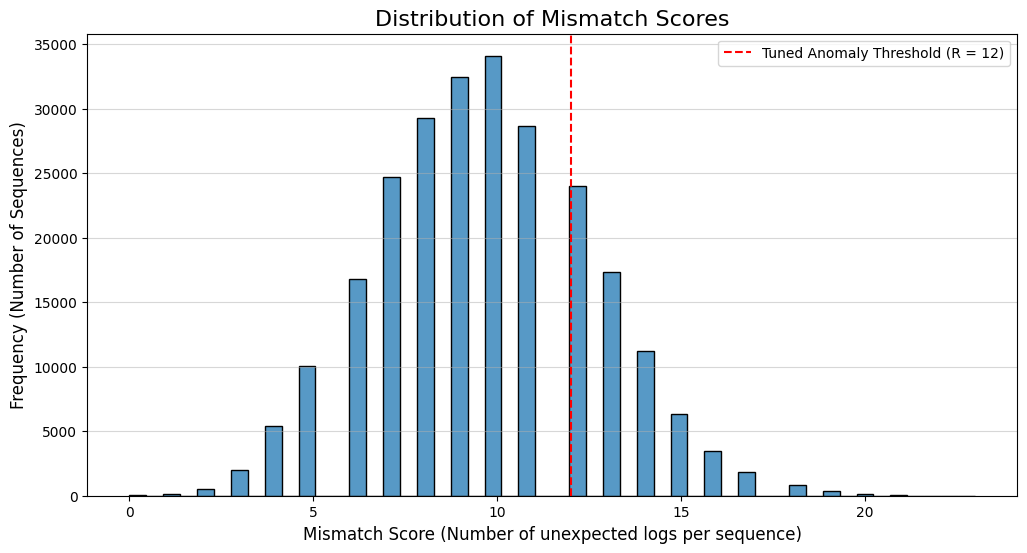


--- Anomaly Detection Summary (with Tuned Threshold) ---
Total sequences evaluated: 249873
Anomaly Threshold (R): A sequence is anomalous if it has > 12 mismatches.
-----------------------------------
Predicted Normal Sequences: 208326
Predicted Anomalous Sequences: 41547
-----------------------------------
Calculated Anomaly Rate: 16.63%

--- Inspecting Top 5 Most Anomalous Sequences (Highest Mismatch Scores) ---


Matching scores to logs: 100%|██████████| 977/977 [00:22<00:00, 42.86it/s]


--- Top Anomaly #1 (Mismatches: 23) ---
>>> Top 5 most frequent templates in this sequence:
<*> <*> Info CBS Appl: Selfupdate, Component: <*> <*> <*> lower version revision holder: <*>                                                                                                41
<*> <*> Info CBS Applicability(ComponentAnalyzerEvaluateSelfUpdate): Component: <*> elevate: <*> applicable(true/false): <*>                                                                37
<*> <*> Info CBS Appl: detect Parent, Package: <*> Parent: <*> Disposition = <*> VersionComp: EQ, ServiceComp: <*> BuildComp: <*> DistributionComp: GE, RevisionComp: GE, Exist: present    12
<*> <*> Info CBS Appl: SelfUpdate detect, component: <*> elevation: <*> applicable: <*>                                                                                                      6
2016-10-25 <*> Info CBS Appl: detectParent: package: <*> <*> <*> <*> <*> <*>                                                                   

In [ ]:
# Cell 5

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

print("Starting results analysis...")

# ===================================================================
# 1. Analyze the Mismatch Distribution
# ===================================================================

# If 'all_mismatch_scores' is not in memory, re-run the calculation.
# This check prevents re-running the long calculation if you already have the data.
if 'all_mismatch_scores' not in locals():
    print("Mismatch scores not found in memory. Re-calculating...")
    all_mismatch_scores = []
    with torch.no_grad():
        for sequences, _ in tqdm(test_loader, desc="Calculating all mismatch scores"):
            sequences = sequences.to(device)
            predictions = model(sequences)
            top_g_predictions = torch.topk(predictions, G, dim=2).indices
            for i in range(sequences.shape[0]):
                mismatch_count = 0
                for j in range(sequences.shape[1]):
                    if sequences[i, j].item() not in top_g_predictions[i, j]:
                        mismatch_count += 1
                all_mismatch_scores.append(mismatch_count)

print("\n--- Mismatch Score Analysis ---")
scores_series = pd.Series(all_mismatch_scores)
print(scores_series.describe())

# ===================================================================
# 2. Tune the Threshold and Visualize
# ===================================================================

# --- THIS IS THE KEY PARAMETER TO TUNE ---
# Based on your output, the 75th percentile is 12. Let's set our threshold there.
R_tuned = 12 

# Plotting the distribution
plt.figure(figsize=(12, 6))
sns.histplot(all_mismatch_scores, bins=50, kde=False) # kde=False can be cleaner for integer data
plt.title('Distribution of Mismatch Scores', fontsize=16)
plt.xlabel('Mismatch Score (Number of unexpected logs per sequence)', fontsize=12)
plt.ylabel('Frequency (Number of Sequences)', fontsize=12)
plt.axvline(x=R_tuned, color='r', linestyle='--', label=f'Tuned Anomaly Threshold (R = {R_tuned})')
plt.legend()
plt.grid(axis='y', alpha=0.5)
plt.show()

# ===================================================================
# 3. Recalculate Summary with the Tuned Threshold
# ===================================================================

predicted_anomalies = sum(1 for score in all_mismatch_scores if score > R_tuned)
predicted_normals = len(all_mismatch_scores) - predicted_anomalies

print("\n--- Anomaly Detection Summary (with Tuned Threshold) ---")
print(f"Total sequences evaluated: {len(all_mismatch_scores)}")
print(f"Anomaly Threshold (R): A sequence is anomalous if it has > {R_tuned} mismatches.")
print("-" * 35)
print(f"Predicted Normal Sequences: {predicted_normals}")
print(f"Predicted Anomalous Sequences: {predicted_anomalies}")
print("-" * 35)
anomaly_rate = (predicted_anomalies / len(all_mismatch_scores)) * 100 if len(all_mismatch_scores) > 0 else 0
print(f"Calculated Anomaly Rate: {anomaly_rate:.2f}%")

# ===================================================================
# 4. Qualitative Analysis: Inspect Top Anomalies
# ===================================================================

print("\n--- Inspecting Top 5 Most Anomalous Sequences (Highest Mismatch Scores) ---")

# We need the original sequences paired with their scores
# Let's rebuild the `anomalous_sequences` list with all scores for sorting
all_sequences_with_scores = []
with torch.no_grad():
    # We need to iterate through the dataloader again to get the original logs
    for i, (sequences, original_logs_batch) in enumerate(tqdm(test_loader, desc="Matching scores to logs")):
        start_index = i * test_loader.batch_size
        end_index = start_index + len(sequences)
        batch_scores = all_mismatch_scores[start_index:end_index]
        
        for j in range(len(sequences)):
            all_sequences_with_scores.append({
                "mismatches": batch_scores[j],
                "sequence": original_logs_batch[j]
            })

# Sort all sequences by their mismatch scores in descending order
sorted_sequences = sorted(all_sequences_with_scores, key=lambda x: x['mismatches'], reverse=True)

# Print the top 5
for i, anomaly in enumerate(sorted_sequences[:5]):
    print(f"\n--- Top Anomaly #{i+1} (Mismatches: {anomaly['mismatches']}) ---")
    
    # Let's count the unique templates in this specific anomalous sequence
    unique_templates = pd.Series([template_miner.add_log_message(log)['template_mined'] for log in anomaly['sequence']]).value_counts()

    print(">>> Top 5 most frequent templates in this sequence:")
    print(unique_templates.head(5).to_string())
    print("\n>>> Full log sequence:")
    for log_line in anomaly['sequence']:
        print(log_line)